In [67]:
import gc
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [2]:
train_data=pd.read_csv("../data/BusinessTrack/RAW_training_set.csv")
test_data=pd.read_csv("../data/BusinessTrack/RAW_test_set.csv")
player_data=pd.read_csv("../data/BusinessTrack/RAW_player_data.csv")
game_data=pd.read_csv("../data/BusinessTrack/RAW_game_data.csv")

# Feature Extraction

## 1 All star number
We believe the number of all star players will play a important role in views prediction  
The intuition is if a team has more popular team players, people are more likely to watch that game

In [3]:
all_start_id = player_data['ASG_Team']!='None'
all_star = player_data.loc[all_start_id,['Team','Name']].sort_values(by='Team').reset_index(drop=True)
all_star = all_star.drop_duplicates().reset_index(drop=True)
all_star_number = all_star.groupby("Team").count().reset_index()
all_star_number.columns = ['Team','Count_ASG']
patch = pd.DataFrame()
patch['Team']=list(set(train_data['Away_Team'])-set(all_star_number['Team']))
patch['Count_ASG']=0
all_star_number=pd.concat([all_star_number,patch],axis=0).reset_index(drop=True)

In [4]:
all_star_number.head()

,Team,Count_ASG
0,ATL,1
1,BOS,3
2,CHA,1
3,CHI,1
4,CLE,3


In [5]:
train_data.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Country,Rounded Viewers
0,2016-17,21600001,10/25/2016,NYK,CLE,C113,18
1,2016-17,21600001,10/25/2016,NYK,CLE,C193,1
2,2016-17,21600001,10/25/2016,NYK,CLE,C126,4
3,2016-17,21600001,10/25/2016,NYK,CLE,C163,11
4,2016-17,21600001,10/25/2016,NYK,CLE,C73,3


In [6]:
train_data=pd.merge(train_data,all_star_number,how='outer',left_on='Away_Team',right_on='Team')
train_data=train_data.drop(columns=['Team']).rename(mapper={"Count_ASG":"Away_Count_ASG"},axis='columns')

In [7]:
train_data=pd.merge(train_data,all_star_number,how='outer',left_on='Home_Team',right_on='Team')
train_data=train_data.drop(columns=['Team']).rename(mapper={"Count_ASG":"Home_Count_ASG"},axis='columns')

In [8]:
test_data=pd.merge(test_data,all_star_number,how='outer',left_on='Away_Team',right_on='Team')
test_data=test_data.drop(columns=['Team']).rename(mapper={"Count_ASG":"Away_Count_ASG"},axis='columns')
test_data=pd.merge(test_data,all_star_number,how='outer',left_on='Home_Team',right_on='Team')
test_data=test_data.drop(columns=['Team']).rename(mapper={"Count_ASG":"Home_Count_ASG"},axis='columns')

## 2.Date
we believe weekday or month will influence the future trend.

In [76]:
train_data['Game_Date']=pd.to_datetime(train_data['Game_Date'])
train_data['day_of_week']=train_data['Game_Date'].dt.weekday_name
train_data['month']=train_data['Game_Date'].dt.month
test_data['Game_Date']=pd.to_datetime(test_data['Game_Date'])
test_data['day_of_week']=test_data['Game_Date'].dt.weekday_name
test_data['month']=test_data['Game_Date'].dt.month
train_data.to_csv("../output/train.csv",index=False)
test_data.to_csv("../output/test.csv",index=False)

In [9]:
train_data=pd.read_csv("../output/train.csv")
test_data=pd.read_csv("../output/test.csv")

## 3.country

In [10]:
print("there are {} countries.".format(len(np.unique(train_data['Country']))))

there are 228 countries.


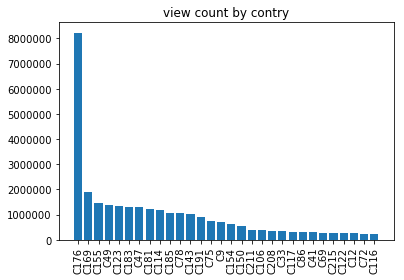

In [11]:
view_table=pd.pivot_table(train_data,values='Rounded Viewers',index='Country',aggfunc=np.sum)
view_table=view_table.sort_values(by=['Rounded Viewers'],ascending=False)
label=view_table.index[0:30]
value=view_table.values[0:30]
index=np.arange(len(label))
plt.bar(index,value)
plt.xticks(index,label,rotation=90)
plt.title("view count by contry")
plt.show()

In [12]:
# choose top 50 and put all other into 'others' catogory

In [13]:
top_50_country=view_table.index[0:50]
top_50_idx=list(map(lambda thiscountry: True if thiscountry in top_50_country else False, train_data['Country']))
not_top_50_idx=[not idx  for idx in top_50_idx]

In [14]:
print ("top 50 country shape",train_data[top_50_idx].shape)

top 50 country shape (99988, 11)


In [17]:
# print("reset shape ",train_data[not_top_50_idx].shape) reset shape  (180637, 11)

In [16]:
# print("total data shape",train_data.shape) total data shape (280625, 11)

In [18]:
top_50_train_data =train_data[top_50_idx].copy()
other=train_data[not_top_50_idx].copy()

In [19]:
other_count=other.groupby(['Game_ID']).sum()
del other_count['month']
del other_count['Away_Count_ASG']
del other_count['Home_Count_ASG']
other_count.reset_index(inplace=True)
del other['Rounded Viewers']
del other['Country']

In [21]:
aggregate_df =pd.DataFrame()
aggregate_df=other.drop_duplicates().reset_index(drop=True)
aggregate_df['Country']='other'
aggregate_df.sort_values(['Game_ID'],inplace=True)
aggregate_df=aggregate_df.merge(other_count, left_on='Game_ID', right_on='Game_ID', how='outer')

In [22]:
new_train_data=pd.concat([aggregate_df,top_50_train_data],axis=0)

In [25]:
# new_train_data.shape

In [26]:
# new_train_data.shape[0]==top_50_train_data.shape[0]+2000 

In [27]:
country_list=list(set(new_train_data['Country']))

In [93]:
# insert country into test_data

In [28]:
country_df=pd.DataFrame(country_list,columns=['Country'])
# country_df
country_df['key'] = 0
test_data['key'] = 0
new_test=pd.merge(test_data,country_df,on='key')
del new_test['key']

In [29]:
# new_test.shape[0]==len(country_df)*len(test_data)

In [132]:
test=new_test
train=new_train_data
# del new_test
# del new_train_data

In [31]:
gc.collect()

12071

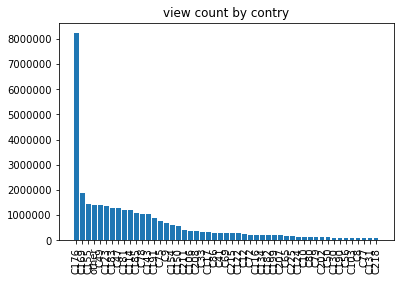

In [32]:
view_table=pd.pivot_table(train,values='Rounded Viewers',index='Country',aggfunc=np.sum)
view_table=view_table.sort_values(by=['Rounded Viewers'],ascending=False)
label=view_table.index
value=view_table.values
index=np.arange(len(label))
plt.bar(index,value)
plt.xticks(index,label,rotation=90)
plt.title("view count by contry")
plt.show()

# Categorical encoder

In [33]:
y_train=train['Rounded Viewers']
y_train_log =np.log1p(y_train)
X_train=train.drop(columns=['Rounded Viewers'])
X_train['month']=X_train['month'].astype('category')
# X_train=pd.get_dummies(X_train,drop_first=True)
del X_train['Game_ID']
del X_train['Game_Date']

In [34]:
X_test=test.drop(columns=['Total_Viewers','Game_ID',"Game_Date"])
X_test['month']=X_test['month'].astype('category')
X_test=X_test.sort_index(axis=1)

In [35]:
cat_col=set(X_train.columns)-set(['Away_Count_ASG','Home_Count_ASG','month'])

In [36]:
for feature in cat_col:
    if feature !="month":
        X_train[feature]=X_train[feature].astype('category')
        X_test[feature]=X_test[feature].astype('category')

# light GBM
LightGBM offers good accuracy with integer-encoded categorical features.   
LightGBM applies Fisher (1958) to find the optimal split over categories as described here. This often performs better than one-hot encoding.  
Use categorical_feature to specify the categorical features. Refer to the parameter categorical_feature in Parameters.  

**Categorical features** must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a **contiguous range of integers**.  

Use **min_data_per_group, cat_smooth** to deal with over-fitting (when #data is small or #category is large).  

For a categorical feature with high cardinality (#category is large), it often works best to treat the feature as numeric, either by simply ignoring the categorical interpretation of the integers or by embedding the categories in a low-dimensional numeric space.  


In [37]:
# model xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor
lgb_model=LGBMRegressor()
lgbm_params = {
#     "n_estimators":60,
    "boosting_type":"dart",
#     "application":"conitunous",
    "learning_rate":0.1,
    "min_data_in_leaf":30,
    "num_leaves":10,
#     "min_data_per_group":[10,30,50],
#     "cat_smooth":[0,0.5,1],
    "max_depth":-1,
#     "scale_pos_weight":2,
#     "drop_rate":0.02,
    "metric":"rmse",
    "min_split_gain":0.0,
#     "colsample_bytree":0.0
}
lgb_model.set_params(**lgbm_params) #base model

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=10,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

###  tune n_booster round/n_estimator

In [185]:
# lgbm_train = lgb.Dataset(data=X_train,
#                           label=y_train_log,
# #                           categorical_feature=cat_col,
#                           free_raw_data=False)

In [38]:
# lgbm_train.categorical_feature

In [39]:
# cv_results = lgb.cv(train_set=lgbm_train,
#                      params=lgbm_params,
#                      nfold=5,
#                      num_boost_round=1000,
#                      early_stopping_rounds=200,
#                      stratified=False,
# #                      objective="regression",
#                      verbose_eval=50,
#                      metrics=['mse'])

In [40]:
# cv_results

In [41]:
# optimum_boost_rounds = np.argmax(cv_results['l2-mean'])
# print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
# print('Best LGBM CV result = {}'.format(np.max(cv_results['l2-mean'])))

In [42]:
# clf = lgb.train(train_set=lgbm_train,
#                  params=lgbm_params,
#                  num_boost_round=60)

# parameter tuning

**max num_leaves**  This is the main parameter to control the complexity of the tree model.   
Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. 

**min_data_in_leaf** This is a very important parameter to prevent over-fitting in a leaf-wise tree.   
Its optimal value depends on the number of training samples and num_leaves.   
Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.   
In practice, setting it to hundreds or thousands is enough for a large dataset.

**max_depth. ** You also can use max_depth to limit the tree depth explicitly.

In [43]:
# from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y, y_pred): 
    return np.mean(np.abs((y - y_pred) / y))
import sklearn.metrics
mape=sklearn.metrics.make_scorer(mean_absolute_percentage_error,greater_is_better=True)

In [44]:
lgb_model

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=10,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [30]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
     "num_leaves":[10,30,50],
#     "cat_smooth":[0,0.5,1],
#  'min_data_in_leaf':list(range(1,100,20))
}
gsearch1 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4,iid=False, cv=5,verbose=20)

gsearch1.fit(X_train,y_train_log)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done   9 out of  15 | elapsed:   30.4s remaining:   20.3s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:   36.1s remaining:   18.0s
[Parallel(n_jobs=4)]: Done  11 out of  15 | elapsed:   44.3s remaining:   16.1s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   45.6s remaining:   11.3s
[Parallel(n_jobs=4)]: Done  13 out of  15 | elapsed:   46.9s remaining:    7.1s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   54.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  15 o

([mean: -0.74573, std: 0.16140, params: {'num_leaves': 10},
  mean: -0.74759, std: 0.17135, params: {'num_leaves': 30},
  mean: -0.74705, std: 0.17403, params: {'num_leaves': 50}],
 {'num_leaves': 10},
 -0.7457297561654588)

In [34]:
param_test2 = {
     "num_leaves":list(range(gsearch1.best_params_['num_leaves']-5,gsearch1.best_params_['num_leaves']+5,2)),
#     "cat_smooth":[0,0.5,1],
#  'min_data_in_leaf':list(range(1,100,20))
}
gsearch2 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test2, scoring='neg_mean_absolute_error',n_jobs=4,iid=False, cv=5,verbose=20)

gsearch2.fit(X_train,y_train_log)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   32.3s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   38.3s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   42.5s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Do

([mean: -0.74415, std: 0.15824, params: {'num_leaves': 5},
  mean: -0.74249, std: 0.15374, params: {'num_leaves': 7},
  mean: -0.74641, std: 0.15861, params: {'num_leaves': 9},
  mean: -0.74913, std: 0.16106, params: {'num_leaves': 11},
  mean: -0.74468, std: 0.16591, params: {'num_leaves': 13}],
 {'num_leaves': 7},
 -0.7424879254015564)

In [35]:
lgb_model.set_params(**gsearch2.best_params_)

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=7,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [38]:
param_test3 = {
 'min_data_in_leaf':list(range(1,1000,100))
}
gsearch3 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose=10)

gsearch3.fit(X_train,y_train_log)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   39.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   55.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.8min finished
C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.85528, std: 0.37442, params: {'min_data_in_leaf': 1},
  mean: -0.85528, std: 0.37442, params: {'min_data_in_leaf': 101},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 201},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 301},
  mean: -0.85529, std: 0.37820, params: {'min_data_in_leaf': 401},
  mean: -0.85529, std: 0.37820, params: {'min_data_in_leaf': 501},
  mean: -0.85609, std: 0.37779, params: {'min_data_in_leaf': 601},
  mean: -0.85458, std: 0.37479, params: {'min_data_in_leaf': 701},
  mean: -0.85458, std: 0.37479, params: {'min_data_in_leaf': 801},
  mean: -0.85458, std: 0.37479, params: {'min_data_in_leaf': 901}],
 {'min_data_in_leaf': 201},
 -0.8538324728486796)

In [41]:
lower_bound=max(0,gsearch3.best_params_['min_data_in_leaf']-50)

In [43]:
param_test3 = {
 'min_data_in_leaf':list(range(lower_bound,gsearch3.best_params_['min_data_in_leaf']+50,10))
}
gsearch3 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose=10)

gsearch3.fit(X_train,y_train_log)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   38.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.8min finished
C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 151},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 161},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 171},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 181},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 191},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 201},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 211},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 221},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 231},
  mean: -0.85383, std: 0.37528, params: {'min_data_in_leaf': 241}],
 {'min_data_in_leaf': 151},
 -0.8538324728486796)

In [44]:
lgb_model.set_params(**gsearch3.best_params_)

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=151,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=7,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [ ]:
# lgb_model.set_params(n_estimators=X_train.shape[1])

In [45]:
lgb_model.fit(X_train,y_train_log)

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=151,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=7,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [46]:
def plot_feature(alg,dtrain,top=100):
    feat_imp = pd.Series(alg.feature_importances_,index=dtrain.columns).sort_values(ascending=False)[0:top]
    feat_imp.plot(kind='bar', title='top {} Feature Importances'.format(top))
    plt.ylabel('Feature Importance Score')
    plt.show()

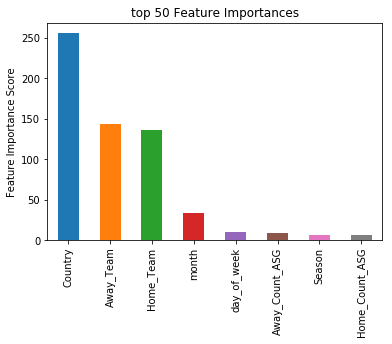

In [47]:
plot_feature(lgb_model,X_train,top=50)

In [51]:
lgb_model

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=151,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=7,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [45]:
lgb_model=LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=151,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=7,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

# evaluation
### k-fold cross-validation

In [49]:
from sklearn.model_selection import KFold
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)

In [98]:
def mean_absolute_percentage_error(y, y_pred): 
    return np.mean(np.abs((y - y_pred) / y))
import sklearn.metrics
mape=sklearn.metrics.make_scorer(mean_absolute_percentage_error,greater_is_better=True)

In [109]:
def cv_mape(model,X_train,y_train,fold=5):
    kf = KFold(n_splits=fold,shuffle=True)
    cv_error_list=[]
    for train_index,test_index in tqdm(kf.split(X_train)):
        model.fit(X_train.loc[train_index],np.log1p(y_train.loc[train_index])) # take logarithm
        pred=np.expm1(model.predict(X_train.loc[test_index])) # restore 
        cv_error_list.append(mean_absolute_percentage_error(y=y_train.loc[test_index],y_pred=pred))
        
    return np.array(cv_error_list)

In [110]:
cv_result=cv_mape(lgb_model,X_train,y_train)

5it [00:09,  1.90s/it]


In [119]:
print("country level score:{} and std{}".format(cv_result.mean(),cv_result.std()))

country level score:0.48719452556823767 and std0.0018991117285270726


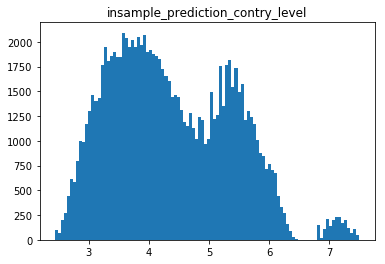

In [122]:
# final score
lgb_model.fit(X_train,np.log1p(y_train))
y_insample_pred=np.expm1(lgb_model.predict(X_train))
plt.hist(np.log1p(y_insample_pred),bins=100)
plt.title("insample_prediction_contry_level")
plt.show()

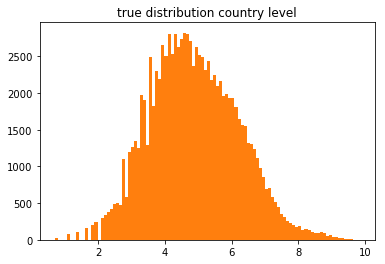

In [124]:
plt.hist(np.log1p(y_train),bins=100)
plt.title("true distribution country level")
plt.show()

In [134]:
train['pred_view']=y_insample_pred

In [138]:
# train.head()

In [136]:
train_game_2000=train[['Game_ID','Rounded Viewers','pred_view']].groupby('Game_ID').sum()

In [137]:
mean_absolute_percentage_error(train_game_2000['Rounded Viewers'],train_game_2000['pred_view'])

0.5038079944518666

# submission

In [142]:
y_pred=np.expm1(lgb_model.predict(X_test))

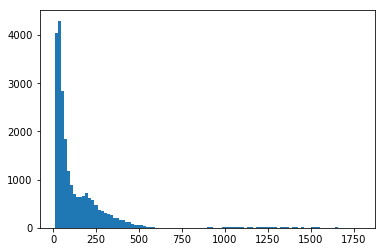

In [143]:
plt.hist(y_pred,bins=100)
plt.show()

In [145]:
# plt.hist(y_train,bins=100)
# plt.show()

In [153]:
test['Total_Viewers']=y_pred

In [154]:
test.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers,Away_Count_ASG,Home_Count_ASG,day_of_week,month,Country
0,2016-17,21600010,2016-10-26,DEN,NOP,302.691241,0,2,Wednesday,10,C169
1,2016-17,21600010,2016-10-26,DEN,NOP,58.160873,0,2,Wednesday,10,C117
2,2016-17,21600010,2016-10-26,DEN,NOP,228.937598,0,2,Wednesday,10,C47
3,2016-17,21600010,2016-10-26,DEN,NOP,209.003197,0,2,Wednesday,10,C114
4,2016-17,21600010,2016-10-26,DEN,NOP,66.044404,0,2,Wednesday,10,C208


In [ ]:
# aggregate over country

In [155]:
submission=test.drop(columns=['month','Country','day_of_week','Away_Count_ASG','Home_Count_ASG'])

In [156]:
submission=submission.groupby(by=['Season','Game_Date','Game_ID','Away_Team','Home_Team']).sum()

In [157]:
submission.reset_index(inplace=True)

In [158]:
submission['Total_Viewers']=submission['Total_Viewers'].round(0)

In [159]:
submission.head()

,Season,Game_Date,Game_ID,Away_Team,Home_Team,Total_Viewers
0,2016-17,2016-10-26,21600010,DEN,NOP,5845.0
1,2016-17,2016-10-28,21600023,HOU,DAL,8641.0
2,2016-17,2016-10-29,21600026,ATL,PHI,8144.0
3,2016-17,2016-10-29,21600027,BOS,CHA,10258.0
4,2016-17,2016-11-01,21600048,LAL,IND,8459.0


In [160]:
submission.to_csv("/output/submission_7_11.csv",index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/output/submission_7_11.csv'